In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import nibabel as nib
from nilearn.plotting import view_img, view_img_on_surf
from nilearn.image import resample_img
import matplotlib.transforms as mtransforms
import cv2
from scipy.spatial.transform import Rotation as R

In [5]:
root_data_dir = 'C:/Users/Henry/Desktop/data' # Change for different systems
subject = 'subject_2'

# 'b' images seem to have fewer things around them, no pins in either
fluorob_jpeg_path = os.path.join(
    root_data_dir,
    os.path.join(
        subject,
        'fluoro_' + subject + 'b.jpg'
    )
)
hull_path = os.path.join(
    root_data_dir,
    os.path.join(
        subject,
        'hull_' + subject + '.nii'
    )
)

preop_CT_path = os.path.join(
    root_data_dir,
    os.path.join(
        subject,
        'preopCT_' + subject + '.nii'
    )
)

In [6]:
preop_CT = nib.load(preop_CT_path)
preop_CT_data = preop_CT.get_fdata()
preop_CT_data.shape

(256, 256, 176)

## Viewing Pre-OP CT and Fluoro

### Finding Pin Locations in CT Scan 3D
Features found manually by clicking through the `viewimg` interface from nilearn package. 

Feature Locations (x,y,z):
- Pin tips:
    - Front Right: (36, 56, 12)
    - Front Left: (-38, 52, 10)
    - Back Right: (52, -74, -28)
    - Back Left: (-40, -80, -32)

In [7]:
view_img(preop_CT)

### Finding Electrodes and Markers in Fluoro Image
__TODO__: Actually find the electrodes

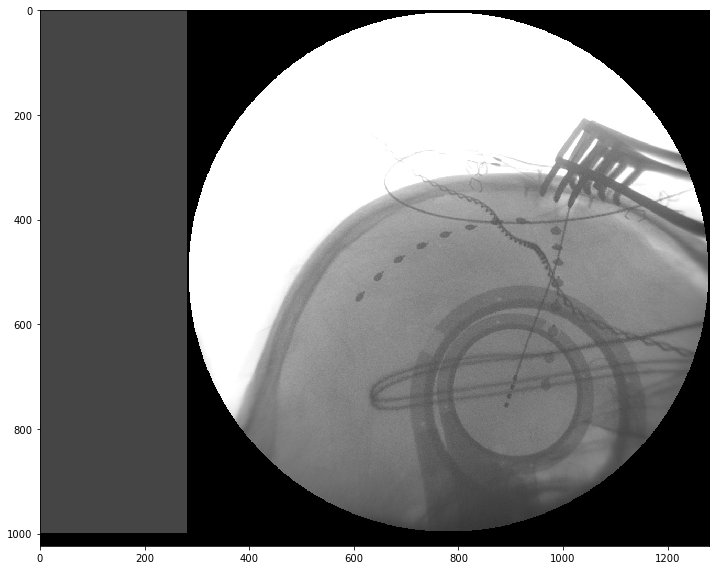

In [10]:
fluorob = mpimg.imread(fluorob_jpeg_path)
fig, ax = plt.subplots(figsize=(12,12))

ax.imshow(fluorob)

### Projecting CT in to 2D

__TODO:__ Actually project using model instead of just taking the mean across an axis

In [29]:
def rotate_3d(nii_data, rotations):
    r = R.from_euler('zyx', rotations, degrees=True)
    rot_matrix = r.as_euler('zxy', degrees=True)
    rotated = resample_img(nii_data, target_affine=rot_matrix)
    return rotated, r

def project_ct(ct_data):
    projection = np.nanmean(ct_data.get_fdata(), axis=0)
    return projection
        
def mirror(seq):
    output = list(seq[::-1])
    return output


LinAlgError: 1-dimensional array given. Array must be at least two-dimensional

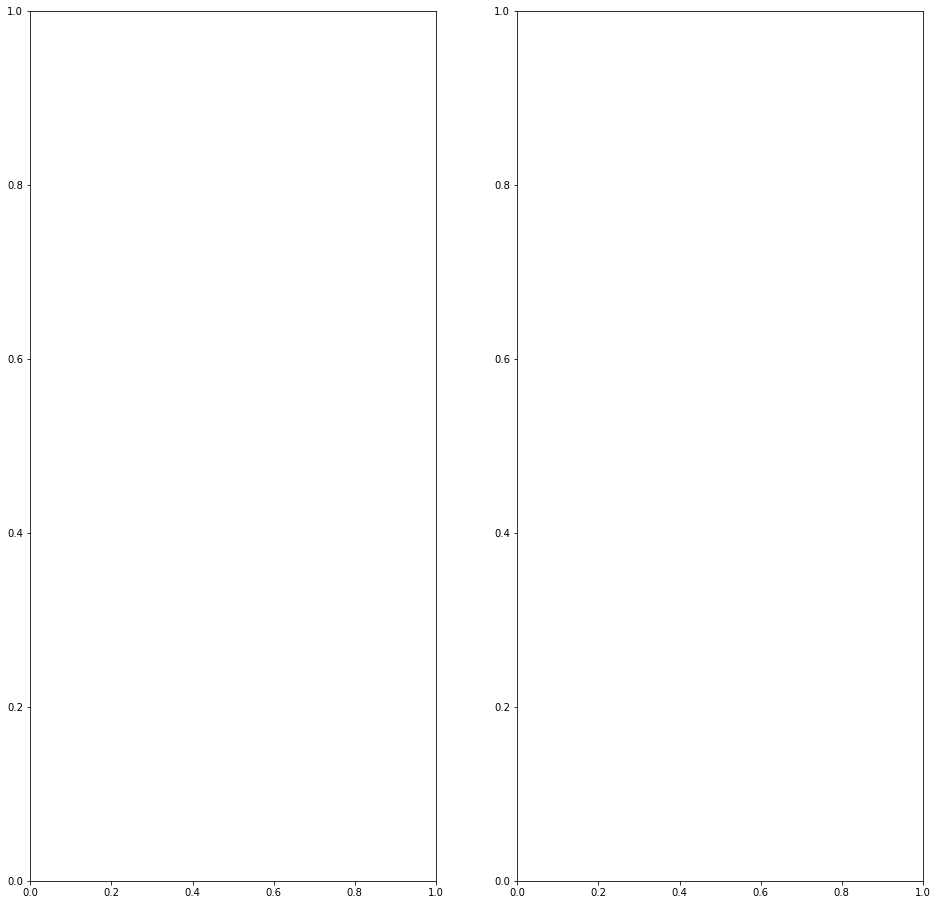

In [30]:
fig, axes = plt.subplots(ncols=2, figsize=(16,16))
euler_rotations=[0, 0, 0]

rotated_ct, r = rotate_3d(preop_CT, rotations=euler_rotations)

ct_proj = project_ct(rotated_ct)

(ct_h, ct_w) = ct_proj.shape
f_h, f_w = fluorob.shape[:2]

scale_factor = ct_h/f_h
dims = (int(f_w * scale_factor), int(f_h * scale_factor))

resize_fluorob = cv2.resize(fluorob, dims, interpolation = cv2.INTER_AREA)


axes[0].imshow(ct_proj)

axes[1].imshow(resize_fluorob)

print('Resized Fluoro Dims: ', resize_fluorob.shape)
print('CT Dims: ', ct_proj.shape)

In [18]:
def rotate_3d(nii_data, rotations):
    r = R.from_euler('xyz', rotations, degrees=True)
    rot_matrix = r.as_dcm()
    rotated = resample_img(nii_data, target_affine=rot_matrix)
    return rotated, r

def project_ct(ct_data):
    projection = np.nanmean(ct_data.get_fdata(), axis=0)
    return projection
        
def mirror(seq):
    output = list(seq[::-1])
    return output

C:\Users\Henry\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  


Resized Fluoro Dims:  (256, 320, 3)
CT Dims:  (256, 176)


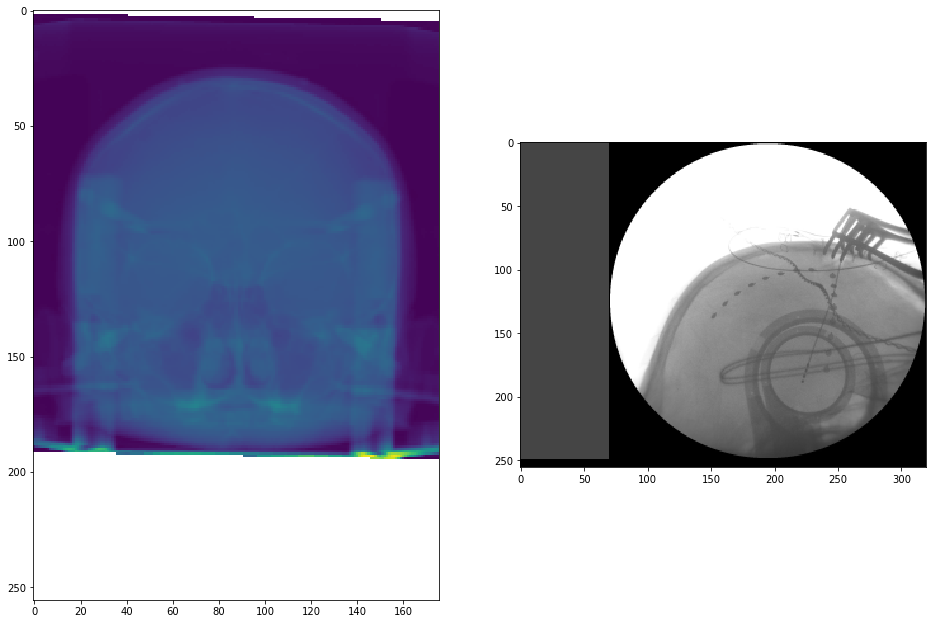

In [15]:
fig, axes = plt.subplots(ncols=2, figsize=(16,16))
euler_rotations=[0, 0, 0]

rotated_ct, r = rotate_3d(preop_CT, rotations=euler_rotations)

ct_proj = project_ct(preop_CT)

(ct_h, ct_w) = ct_proj.shape
f_h, f_w = fluorob.shape[:2]

scale_factor = ct_h/f_h
dims = (int(f_w * scale_factor), int(f_h * scale_factor))

resize_fluorob = cv2.resize(fluorob, dims, interpolation = cv2.INTER_AREA)


axes[0].imshow(ct_proj)

axes[1].imshow(resize_fluorob)

print('Resized Fluoro Dims: ', resize_fluorob.shape)
print('CT Dims: ', ct_proj.shape)

## Shift/Scale Fluoro to isolate x/y electrode coordinates on CT projection

- Fluro image is rescaled to match the shape of the ct scan projection for easier comparison
    - Height is matched, width scaled accordingly

In [9]:
(ct_h, ct_w) = ct_proj.shape
f_h, f_w = fluorob.shape[:2]

scale_factor = ct_h/f_h
dims = (int(f_w * scale_factor), int(f_h * scale_factor))

resize_fluorob = cv2.resize(fluorob, dims, interpolation = cv2.INTER_AREA)
print('Resized Fluoro Dims: ', resize_fluorob.shape)
print('CT Dims: ', ct_proj.shape)

Resized Fluoro Dims:  (369, 461, 3)
CT Dims:  (369, 330)


In [10]:
def rotate_scale(image, scale_factor, rotation, x_translate, y_translate):
    (h, w) = image.shape[:2]
    rotation_matrix = cv2.getRotationMatrix2D((w/2, h/2), rotation, scale_factor)
    translation_matrix = np.array([[1,0,w * x_translate], [0,1,h * y_translate]])
    translated = cv2.warpAffine(image, translation_matrix, (w, h))
    rotated = cv2.warpAffine(translated, rotation_matrix, (w, h))
    return rotated

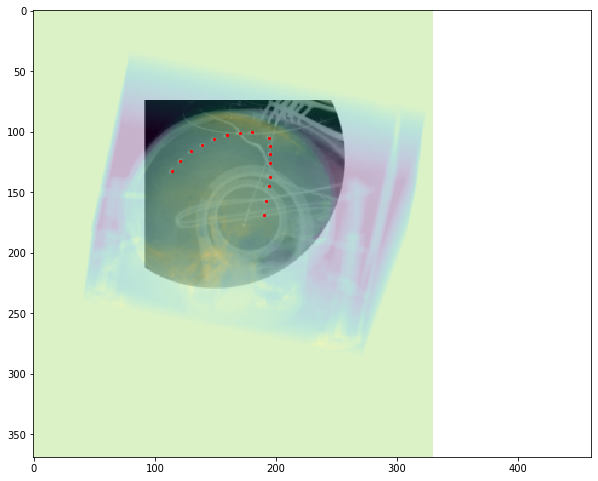

In [11]:
fig, ax = plt.subplots(figsize=(10,10))
scale_factor = .6
rotation = 0
x_trans = -0.4
y_trans = -0.27

#rotated_fluorob = rotate_scale(fluorob, scale_factor, rotation)
shifted_fluoro = rotate_scale(resize_fluorob, scale_factor, rotation, x_trans, y_trans)
ax.imshow(ct_proj, alpha=1)
ax.imshow(np.max(shifted_fluoro) - shifted_fluoro , alpha=.7) # Inverted colors to better see
electrode_locs = [
    [114, 132],
    [121, 124],
    [130, 116],
    [139, 111],
    [149, 106],
    [160, 103],
    [170, 101],
    [180, 100],
    [194, 105],
    [195, 112],
    [195, 118],
    [195, 126],
    [195, 137],
    [194, 145],
    [192, 157],
    [190, 169]
    
    

] # array of x,y pairs

for (y, z) in electrode_locs:
    ax.scatter([y], [z], c='r', s=5) # Scatter on electrode locations


## Steps to get Electrode from 2d in to 3d
1. Assume at front (0) of axis 0
2. Import and rotate hull
2. For each electrode calculate intersections with Cortext along axis 0
3. Picks first electrode location intersection
4. Uses rotated hull's affine to turn from voxel sapce to millimeter space


In [12]:
hull = nib.load(hull_path)

In [13]:
hull_data = hull.get_fdata()
print(np.unique(hull_data))

[0. 1.]


In [14]:
rot_hull, r = rotate_3d(hull, euler_rotations)
rot_hull_data = rot_hull.get_fdata()

In [15]:
print(len(np.unique(rot_hull_data)))

3084728


In [16]:
print(np.min(np.unique(rot_hull_data)))
print(np.max(np.unique(rot_hull_data)))
print(np.mean(rot_hull_data))
print(np.median(rot_hull_data))

0.0
1.0
0.0017578968884515568
0.0


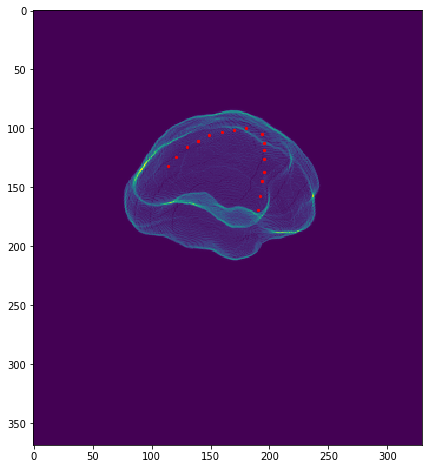

In [17]:
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(np.mean(rot_hull.get_fdata(), axis=0))
for (y, z) in electrode_locs:
    ax.scatter([y], [z], c='r', s=5) # Scatter on electrode locations

In [52]:
intersections = []
for (y, z) in electrode_locs:
    num_locs = 0
    elec_intersections = []
    for x in range(rot_hull_data.shape[0]):
        if rot_hull_data[x][y][z] > 0.002:
            num_locs += 1
            elec_intersections.append([x,y,z])
    if elec_intersections:
        intersections.append(elec_intersections[0])
    else:
        print('No intersections', y,z)


print(intersections)

[[76, 114, 132], [77, 121, 124], [77, 130, 116], [74, 139, 111], [74, 149, 106], [73, 160, 103], [77, 170, 101], [80, 180, 100], [91, 194, 105], [92, 195, 112], [78, 195, 118], [76, 195, 126], [71, 195, 137], [68, 194, 145], [67, 192, 157], [69, 190, 169]]


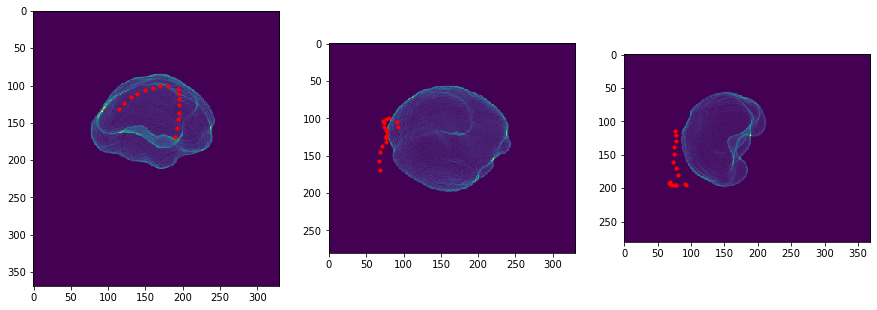

In [54]:
fig, ax = plt.subplots(ncols=3, figsize=(15,8))
ax[0].imshow(np.mean(rot_hull.get_fdata(), axis=0))
ax[1].imshow(np.mean(rot_hull.get_fdata(), axis=1))
ax[2].imshow(np.mean(rot_hull.get_fdata(), axis=2))
s=10
for (x,y,z) in intersections:
    ax[0].scatter([y], [z], color = 'r', s=s)
    ax[1].scatter([x], [z], color = 'r', s=s)
    ax[2].scatter([x], [y], color = 'r', s=s)

In [55]:
mapped_coords = nib.affines.apply_affine(rot_hull.affine, intersections)
print(mapped_coords)

[[-31.25415615 -68.37058687  50.46502255]
 [-32.57625326 -73.80614492  41.37069642]
 [-35.57557153 -78.84284961  30.85234599]
 [-41.49506539 -81.53189337  22.3242374 ]
 [-45.01421181 -83.45039475  11.88704616]
 [-49.93062766 -83.35959828   1.55164045]
 [-49.89203362 -81.78820735  -9.28944995]
 [-50.82683145 -79.43426277 -19.4671264 ]
 [-46.14975753 -68.976475   -33.98469005]
 [-45.93607025 -61.91217755 -32.95997578]
 [-59.17975408 -58.52226297 -26.24333095]
 [-61.41438954 -51.28277834 -22.98814022]
 [-66.5692006  -41.69563277 -17.74270765]
 [-69.35335035 -34.9003387  -13.26247456]
 [-70.10266582 -24.27678921  -7.29768432]
 [-68.07573155 -13.16371199  -2.3589545 ]]


In [58]:


pd.DataFrame.from_dict(
    {
        i: mapped_coords[i] for i in range(len(mapped_coords))
    },
)

TypeError: from_dict() got an unexpected keyword argument 'index'